In [1]:
"""
Analyze GRASP for each detector design
author: Jiancheng Zeng
Date: May 1, 2023
"""

'\nAnalyze GRASP for each detector design\nauthor: Jiancheng Zeng\nDate: May 1, 2023\n'

In [2]:
"""
RUN THIS BLOCK before others!
You don't need to change anything in this code block unless you want to define your own changes.
This block is for defining functions that will be used for analysis
"""

import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import toy_model_analysis

Reading data...

Toy Model data imported
Found 6507 Events!
Now processing (6506/6507)
 We got 1282 events selected
Last event is 9997433
Reading data...

Toy Model data imported
Found 6891 Events!
Now processing (6890/6891)
 We got 1392 events selected
Last event is 9994842
Reading data...

Toy Model data imported
Found 7212 Events!
Now processing (7211/7212)
 We got 1456 events selected
Last event is 9997315
Reading data...

Toy Model data imported
Found 7771 Events!
Now processing (7770/7771)
 We got 1609 events selected
Last event is 9998566
Reading data...

Toy Model data imported
Found 8099 Events!
Now processing (8098/8099)
 We got 1708 events selected
Last event is 9996522
Reading data...

Toy Model data imported
Found 8605 Events!
Now processing (8604/8605)
 We got 1791 events selected
Last event is 9997713
Reading data...

Toy Model data imported
Found 8708 Events!
Now processing (8707/8708)
 We got 1772 events selected
Last event is 9999959
Reading data...

Toy Model data im

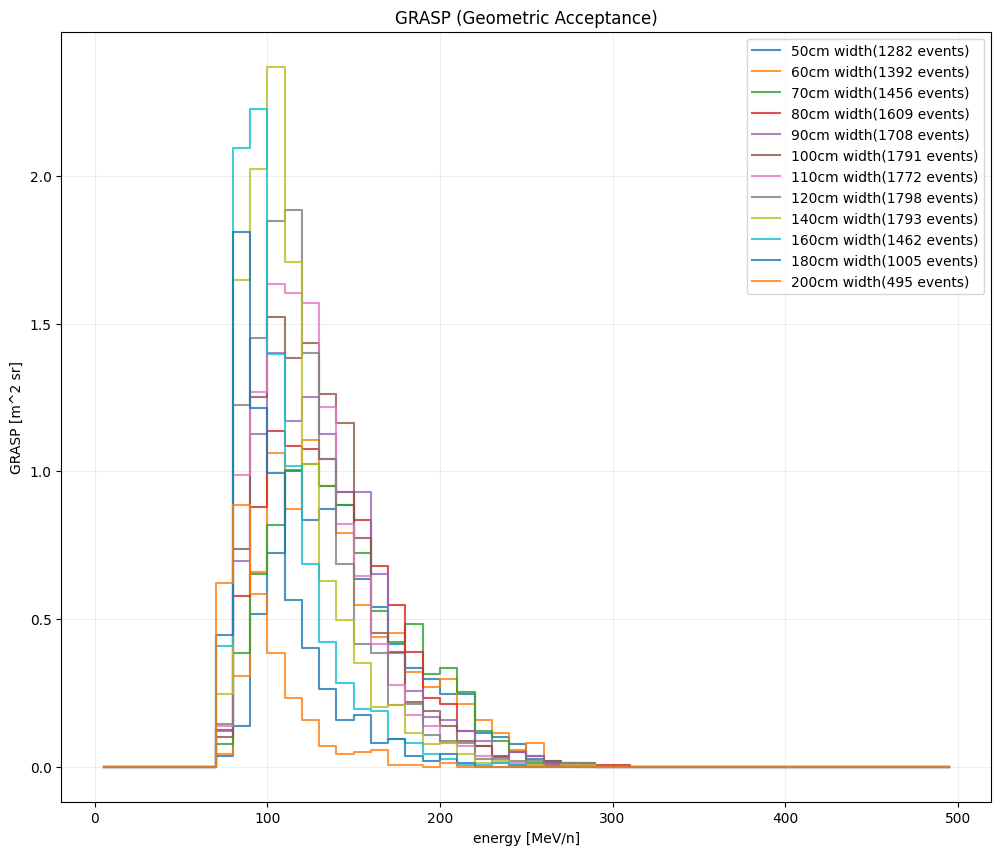

In [3]:
fig, ax = plt.subplots(figsize=(12, 10))

Events_900_Stop = []
TPC_length_900 = []

plt.figure(1)

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_900kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_50[0]))
TPC_length_900.append(50)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = toy_model_analysis.GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm_900kgTPC.dat'
label_60cm= '60cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_60[0]))
TPC_length_900.append(60)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = toy_model_analysis.GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_70 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_70cm_900kgTPC.dat'
label_70cm= '70cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_70 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_70), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_70[0]))
TPC_length_900.append(70)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_70 = toy_model_analysis.GRASP_hist(GRASP_1e7_70[0], -1000010020, label_70cm, GRASP_1e7_70[1], 0, 1000, 50, ax=ax)
GRASP_1e7_70 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm_900kgTPC.dat'
label_80cm= '80cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_80[0]))
TPC_length_900.append(80)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = toy_model_analysis.GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm_900kgTPC.dat'
label_90cm= '90cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_90[0]))
TPC_length_900.append(90)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = toy_model_analysis.GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm_900kgTPC.dat'
label_100cm= '100cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_100[0]))
TPC_length_900.append(100)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = toy_model_analysis.GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_900kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_110[0]))
TPC_length_900.append(110)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = toy_model_analysis.GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm_900kgTPC.dat'
label_120cm= '120cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_120[0]))
TPC_length_900.append(120)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = toy_model_analysis.GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm_900kgTPC.dat'
label_140cm= '140cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_140[0]))
TPC_length_900.append(140)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = toy_model_analysis.GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm_900kgTPC.dat'
label_160cm= '160cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_160[0]))
TPC_length_900.append(160)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = toy_model_analysis.GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm_900kgTPC.dat'
label_180cm= '180cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_180[0]))
TPC_length_900.append(180)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = toy_model_analysis.GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_200cm_900kgTPC.dat'
label_200cm= '200cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_200 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_200), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_200[0]))
TPC_length_900.append(200)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_200 = toy_model_analysis.GRASP_hist(GRASP_1e7_200[0], -1000010020, label_200cm, GRASP_1e7_200[1], 0, 1000, 50, ax=ax)
GRASP_1e7_200 = None

file_path_atmo_1e7_600 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_600cm_900kgTPC.dat'
label_600cm= '600cm width'

"""
# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_600 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_600), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_600[0]))
TPC_length_900.append(600)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_600 = toy_model_analysis.GRASP_hist(GRASP_1e7_600[0], -1000010020, label_600cm, GRASP_1e7_600[1], 0, 1000, 50, ax=ax)
GRASP_1e7_600 = None

file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm_900kgTPC.dat'
label_1000cm= '1000cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=True, in_flight_event=False)
Events_900_Stop.append(len(GRASP_1e7_1000[0]))
TPC_length_900.append(1000)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = toy_model_analysis.GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None
"""


plt.show()  # Display the plot with both data on the same axes

Reading data...

Toy Model data imported
Found 6507 Events!
Now processing (6506/6507)
 We got 5225 events selected
Last event is 9997433
Reading data...

Toy Model data imported
Found 6891 Events!
Now processing (6890/6891)
 We got 5499 events selected
Last event is 9994842
Reading data...

Toy Model data imported
Found 7212 Events!
Now processing (7211/7212)
 We got 5756 events selected
Last event is 9997315
Reading data...

Toy Model data imported
Found 7771 Events!
Now processing (7770/7771)
 We got 6162 events selected
Last event is 9998566
Reading data...

Toy Model data imported
Found 8099 Events!
Now processing (8098/8099)
 We got 6391 events selected
Last event is 9996522
Reading data...

Toy Model data imported
Found 8605 Events!
Now processing (8604/8605)
 We got 6814 events selected
Last event is 9997713
Reading data...

Toy Model data imported
Found 8708 Events!
Now processing (8707/8708)
 We got 6936 events selected
Last event is 9999959
Reading data...

Toy Model data im

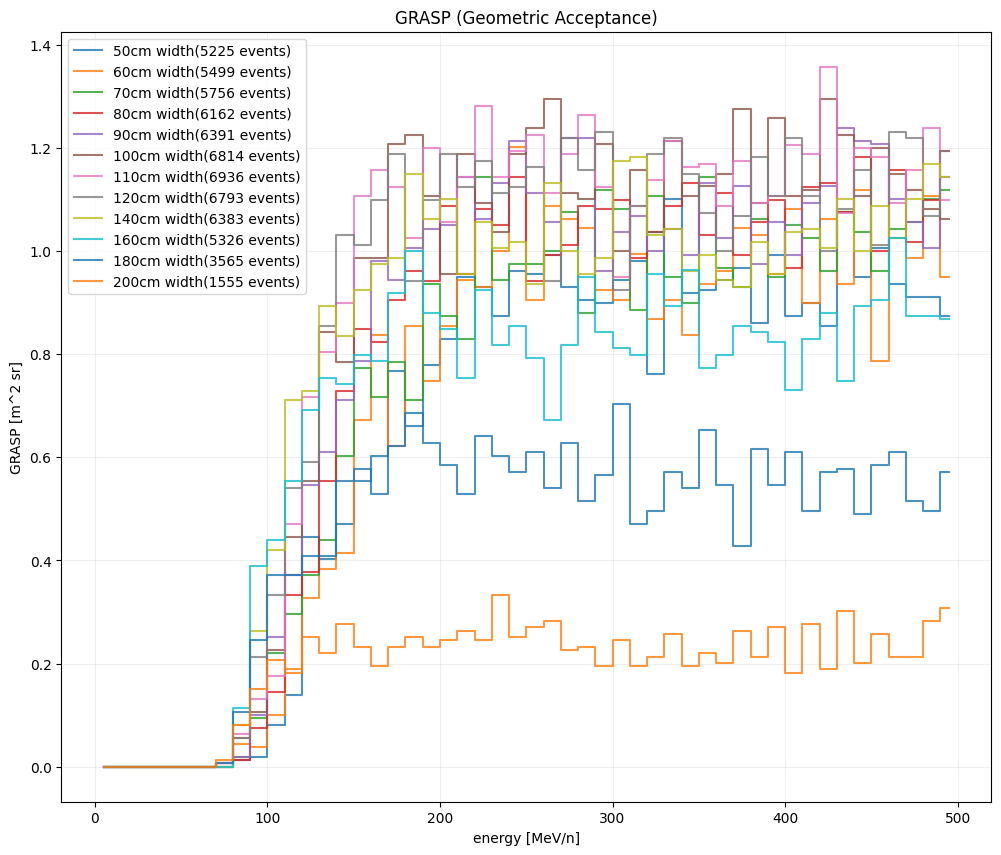

In [4]:
fig, ax = plt.subplots(figsize=(12, 10))

Events_900_In_Flight = []
TPC_length_900 = []

plt.figure(1)

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_900kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_50[0]))
TPC_length_900.append(50)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = toy_model_analysis.GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm_900kgTPC.dat'
label_60cm= '60cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_60[0]))
TPC_length_900.append(60)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = toy_model_analysis.GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_70 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_70cm_900kgTPC.dat'
label_70cm= '70cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_70 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_70), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_70[0]))
TPC_length_900.append(70)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_70 = toy_model_analysis.GRASP_hist(GRASP_1e7_70[0], -1000010020, label_70cm, GRASP_1e7_70[1], 0, 1000, 50, ax=ax)
GRASP_1e7_70 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm_900kgTPC.dat'
label_80cm= '80cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_80[0]))
TPC_length_900.append(80)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = toy_model_analysis.GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm_900kgTPC.dat'
label_90cm= '90cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_90[0]))
TPC_length_900.append(90)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = toy_model_analysis.GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm_900kgTPC.dat'
label_100cm= '100cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_100[0]))
TPC_length_900.append(100)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = toy_model_analysis.GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_900kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_110[0]))
TPC_length_900.append(110)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = toy_model_analysis.GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm_900kgTPC.dat'
label_120cm= '120cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_120[0]))
TPC_length_900.append(120)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = toy_model_analysis.GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm_900kgTPC.dat'
label_140cm= '140cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_140[0]))
TPC_length_900.append(140)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = toy_model_analysis.GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm_900kgTPC.dat'
label_160cm= '160cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_160[0]))
TPC_length_900.append(160)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = toy_model_analysis.GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm_900kgTPC.dat'
label_180cm= '180cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_180[0]))
TPC_length_900.append(180)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = toy_model_analysis.GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_200cm_900kgTPC.dat'
label_200cm= '200cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_200 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_200), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_200[0]))
TPC_length_900.append(200)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_200 = toy_model_analysis.GRASP_hist(GRASP_1e7_200[0], -1000010020, label_200cm, GRASP_1e7_200[1], 0, 1000, 50, ax=ax)
GRASP_1e7_200 = None

file_path_atmo_1e7_600 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_600cm_900kgTPC.dat'
label_600cm= '600cm width'

"""
# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_600 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_600), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_600[0]))
TPC_length_900.append(600)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_600 = toy_model_analysis.GRASP_hist(GRASP_1e7_600[0], -1000010020, label_600cm, GRASP_1e7_600[1], 0, 1000, 50, ax=ax)
GRASP_1e7_600 = None

file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm_900kgTPC.dat'
label_1000cm= '1000cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=False, in_flight_event=True)
Events_900_In_Flight.append(len(GRASP_1e7_1000[0]))
TPC_length_900.append(1000)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = toy_model_analysis.GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None
"""


plt.show()  # Display the plot with both data on the same axes

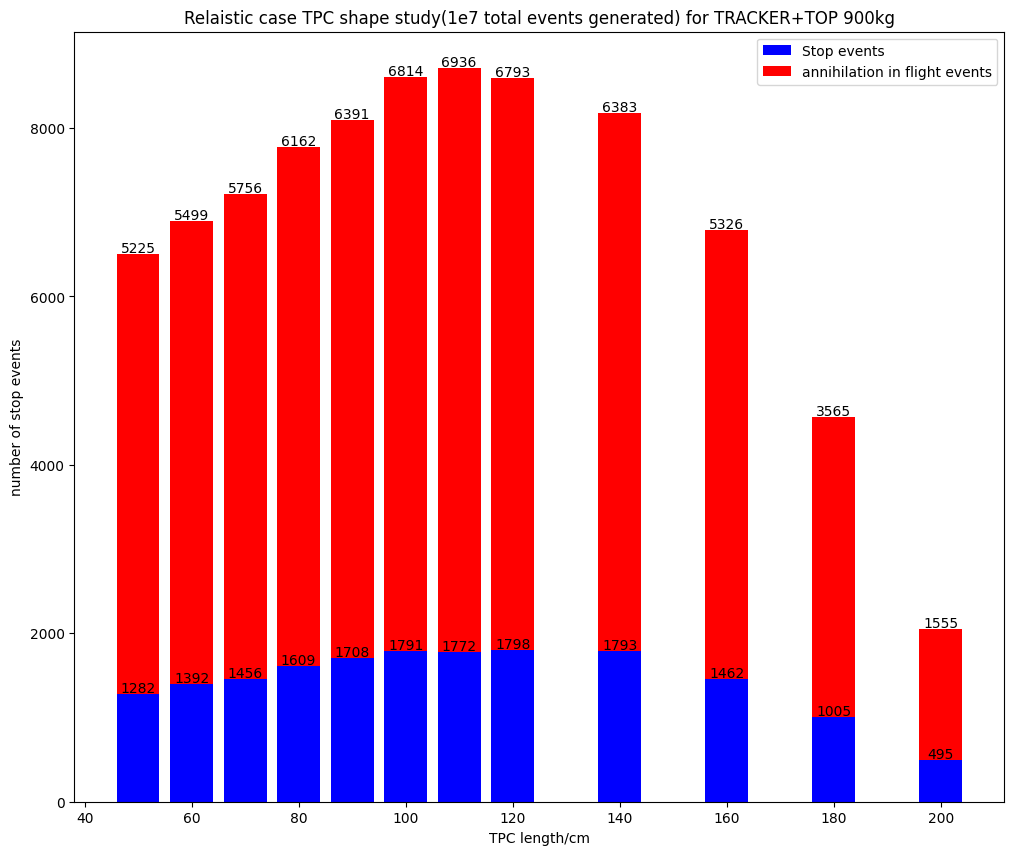

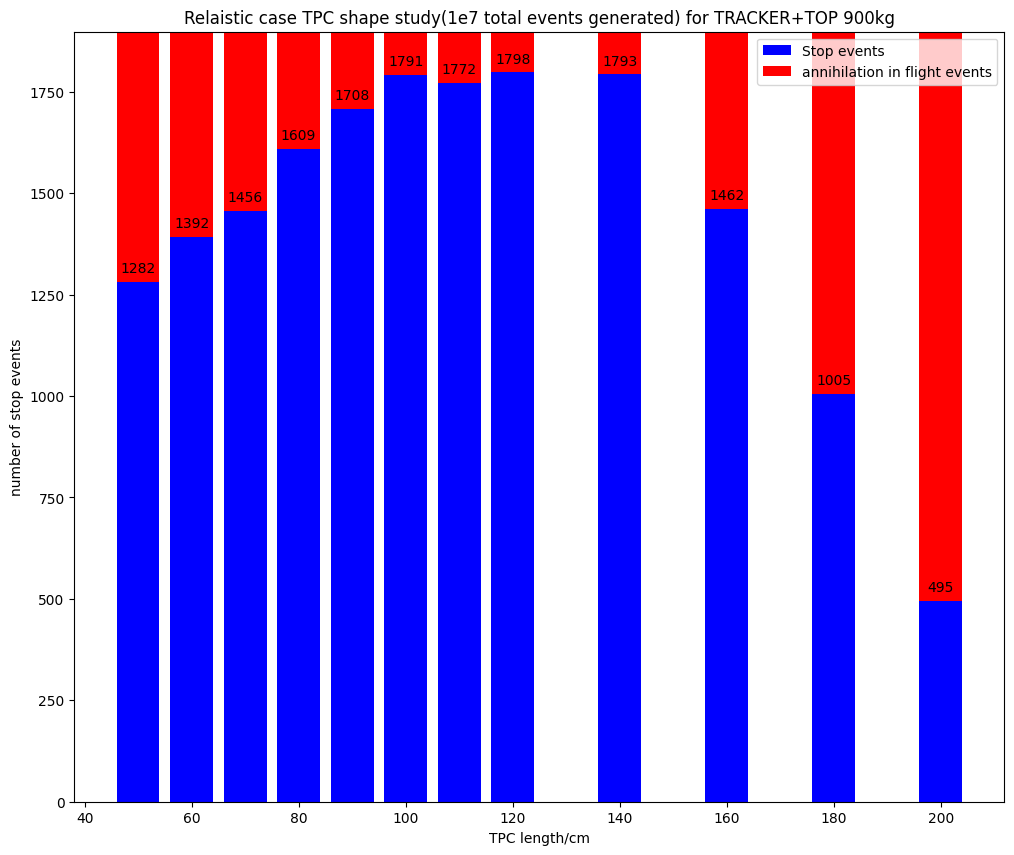

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(1)
plt.bar(TPC_length_900, Events_900_Stop, color='b', label='Stop events', width=8)
plt.bar(TPC_length_900, Events_900_In_Flight, color='r', bottom=Events_900_Stop, label='annihilation in flight events', width=8)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("Relaistic case TPC shape study(1e7 total events generated) for TRACKER+TOP 900kg")
for i, v in enumerate(Events_900_Stop):
    plt.text(TPC_length_900[i], Events_900_Stop[i]+150, str(v), ha='center', va='top')
for i, v in enumerate(Events_900_In_Flight):
    plt.text(TPC_length_900[i], Events_900_Stop[i]+Events_900_In_Flight[i]+150, str(v), ha='center', va='top')
plt.legend()

fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(2)
plt.bar(TPC_length_900, Events_900_Stop, color='b', label='Stop events', width=8)
plt.bar(TPC_length_900, Events_900_In_Flight, color='r', bottom=Events_900_Stop, label='annihilation in flight events', width=8)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("Relaistic case TPC shape study(1e7 total events generated) for TRACKER+TOP 900kg")
for i, v in enumerate(Events_900_Stop):
    plt.text(TPC_length_900[i], Events_900_Stop[i]+50, str(v), ha='center', va='top')
plt.ylim(0, max(Events_900_Stop)+100)
plt.legend()


Reading data...

Toy Model data imported
Found 13091 Events!
Now processing (13090/13091)
 We got 2569 events selected
Last event is 9999684
Reading data...

Toy Model data imported
Found 13380 Events!
Now processing (13379/13380)
 We got 2658 events selected
Last event is 9999877
Reading data...

Toy Model data imported
Found 13384 Events!
Now processing (13383/13384)
 We got 2656 events selected
Last event is 9999742
Reading data...

Toy Model data imported
Found 13941 Events!
Now processing (13940/13941)
 We got 2730 events selected
Last event is 9999554
Reading data...

Toy Model data imported
Found 14833 Events!
Now processing (14832/14833)
 We got 2892 events selected
Last event is 9999849
Reading data...

Toy Model data imported
Found 15385 Events!
Now processing (15384/15385)
 We got 3029 events selected
Last event is 9999761
Reading data...

Toy Model data imported
Found 16548 Events!
Now processing (16547/16548)
 We got 3319 events selected
Last event is 9997487
Reading data.

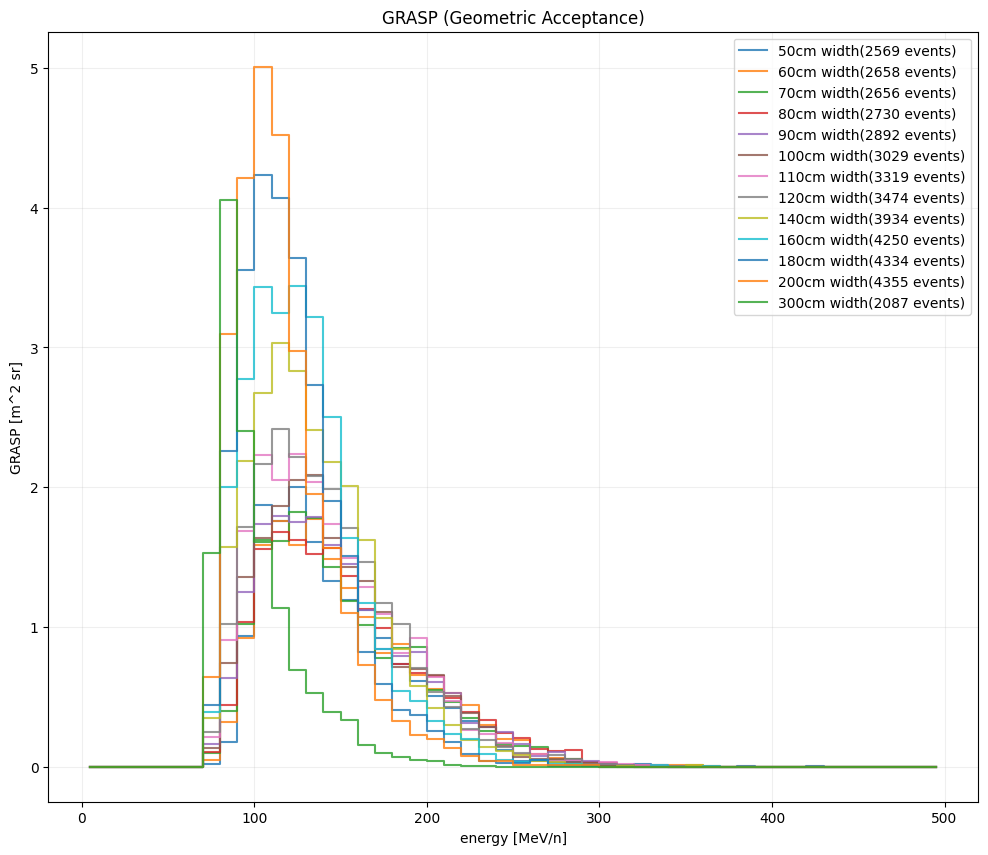

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))

Events_1500_Stop = []
TPC_length_1500 = []

plt.figure(1)

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_1500kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_50[0]))
TPC_length_1500.append(50)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = toy_model_analysis.GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm_1500kgTPC.dat'
label_60cm= '60cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_60[0]))
TPC_length_1500.append(60)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = toy_model_analysis.GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_70 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_70cm_1500kgTPC.dat'
label_70cm= '70cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_70 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_70), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_70[0]))
TPC_length_1500.append(70)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_70 = toy_model_analysis.GRASP_hist(GRASP_1e7_70[0], -1000010020, label_70cm, GRASP_1e7_70[1], 0, 1000, 50, ax=ax)
GRASP_1e7_70 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm_1500kgTPC.dat'
label_80cm= '80cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_80[0]))
TPC_length_1500.append(80)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = toy_model_analysis.GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm_1500kgTPC.dat'
label_90cm= '90cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_90[0]))
TPC_length_1500.append(90)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = toy_model_analysis.GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm_1500kgTPC.dat'
label_100cm= '100cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_100[0]))
TPC_length_1500.append(100)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = toy_model_analysis.GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_1500kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_110[0]))
TPC_length_1500.append(110)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = toy_model_analysis.GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm_1500kgTPC.dat'
label_120cm= '120cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_120[0]))
TPC_length_1500.append(120)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = toy_model_analysis.GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm_1500kgTPC.dat'
label_140cm= '140cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_140[0]))
TPC_length_1500.append(140)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = toy_model_analysis.GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm_1500kgTPC.dat'
label_160cm= '160cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_160[0]))
TPC_length_1500.append(160)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = toy_model_analysis.GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm_1500kgTPC.dat'
label_180cm= '180cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_180[0]))
TPC_length_1500.append(180)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = toy_model_analysis.GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_200cm_1500kgTPC.dat'
label_200cm= '200cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_200 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_200), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_200[0]))
TPC_length_1500.append(200)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_200 = toy_model_analysis.GRASP_hist(GRASP_1e7_200[0], -1000010020, label_200cm, GRASP_1e7_200[1], 0, 1000, 50, ax=ax)
GRASP_1e7_200 = None

file_path_atmo_1e7_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_300cm_1500kgTPC.dat'
label_300cm= '300cm width'


# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_300 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_300), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_300[0]))
TPC_length_1500.append(300)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_300 = toy_model_analysis.GRASP_hist(GRASP_1e7_300[0], -1000010020, label_300cm, GRASP_1e7_300[1], 0, 1000, 50, ax=ax)
GRASP_1e7_300 = None

"""
file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm_1500kgTPC.dat'
label_1000cm= '1000cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=True, in_flight_event=False)
Events_1500_Stop.append(len(GRASP_1e7_1000[0]))
TPC_length_1500.append(1000)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = toy_model_analysis.GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None
"""

plt.show()  # Display the plot with both data on the same axes

Reading data...

Toy Model data imported
Found 8930 Events!
Now processing (8929/8930)
 We got 7185 events selected
Last event is 9997559
Reading data...

Toy Model data imported
Found 9060 Events!
Now processing (9059/9060)
 We got 7224 events selected
Last event is 9998357
Reading data...

Toy Model data imported
Found 9559 Events!
Now processing (9558/9559)
 We got 7652 events selected
Last event is 9997532
Reading data...

Toy Model data imported
Found 10110 Events!
Now processing (10109/10110)
 We got 8062 events selected
Last event is 9999488
Reading data...

Toy Model data imported
Found 10645 Events!
Now processing (10644/10645)
 We got 8521 events selected
Last event is 9999354
Reading data...

Toy Model data imported
Found 11325 Events!
Now processing (11324/11325)
 We got 8993 events selected
Last event is 9999976
Reading data...

Toy Model data imported
Found 11611 Events!
Now processing (11610/11611)
 We got 9247 events selected
Last event is 9999548
Reading data...

Toy M

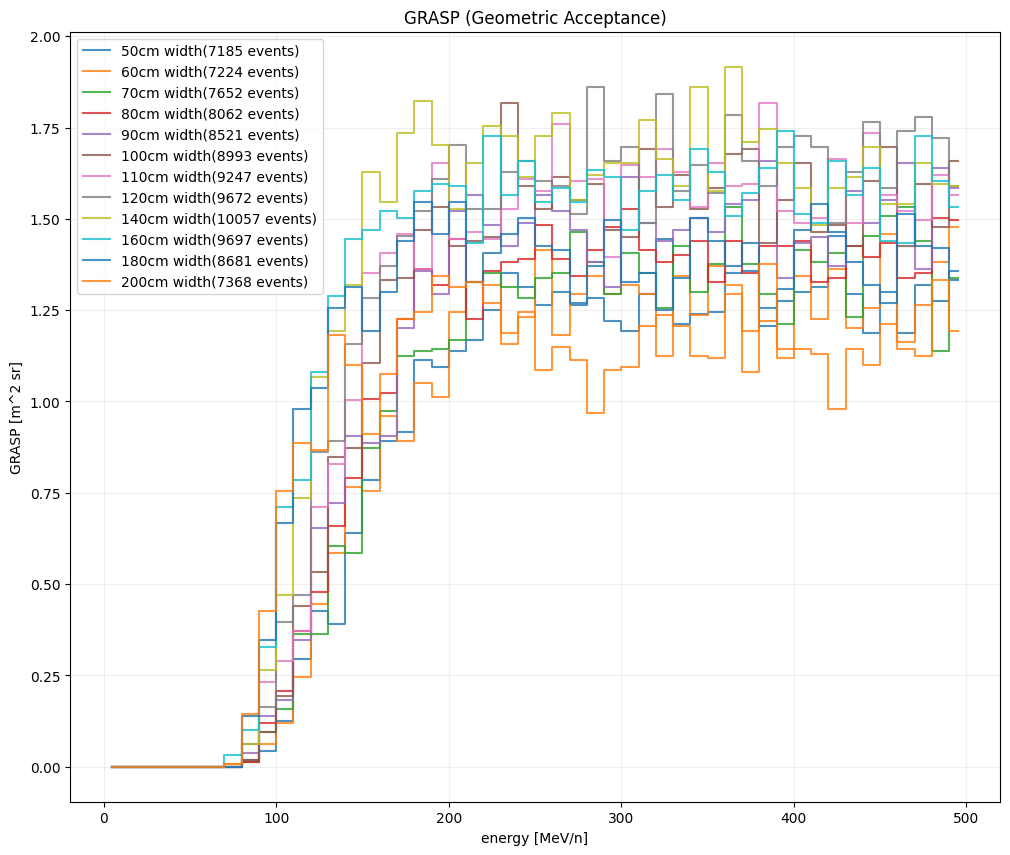

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

Events_1100_In_Flight = []
TPC_length_1100 = []

plt.figure(1)

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_1100kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_50[0]))
TPC_length_1100.append(50)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = toy_model_analysis.GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm_1100kgTPC.dat'
label_60cm= '60cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_60[0]))
TPC_length_1100.append(60)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = toy_model_analysis.GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_70 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_70cm_1100kgTPC.dat'
label_70cm= '70cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_70 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_70), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_70[0]))
TPC_length_1100.append(70)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_70 = toy_model_analysis.GRASP_hist(GRASP_1e7_70[0], -1000010020, label_70cm, GRASP_1e7_70[1], 0, 1000, 50, ax=ax)
GRASP_1e7_70 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm_1100kgTPC.dat'
label_80cm= '80cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_80[0]))
TPC_length_1100.append(80)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = toy_model_analysis.GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm_1100kgTPC.dat'
label_90cm= '90cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_90[0]))
TPC_length_1100.append(90)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = toy_model_analysis.GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm_1100kgTPC.dat'
label_100cm= '100cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_100[0]))
TPC_length_1100.append(100)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = toy_model_analysis.GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_1100kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_110[0]))
TPC_length_1100.append(110)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = toy_model_analysis.GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm_1100kgTPC.dat'
label_120cm= '120cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_120[0]))
TPC_length_1100.append(120)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = toy_model_analysis.GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm_1100kgTPC.dat'
label_140cm= '140cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_140[0]))
TPC_length_1100.append(140)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = toy_model_analysis.GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm_1100kgTPC.dat'
label_160cm= '160cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_160[0]))
TPC_length_1100.append(160)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = toy_model_analysis.GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm_1100kgTPC.dat'
label_180cm= '180cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_180[0]))
TPC_length_1100.append(180)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = toy_model_analysis.GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_200cm_1100kgTPC.dat'
label_200cm= '200cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_200 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_200), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_200[0]))
TPC_length_1100.append(200)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_200 = toy_model_analysis.GRASP_hist(GRASP_1e7_200[0], -1000010020, label_200cm, GRASP_1e7_200[1], 0, 1000, 50, ax=ax)
GRASP_1e7_200 = None

"""
file_path_atmo_1e7_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_300cm_1100kgTPC.dat'
label_300cm= '300cm width'


# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_300 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_300), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_300[0]))
TPC_length_1100.append(300)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_300 = toy_model_analysis.GRASP_hist(GRASP_1e7_300[0], -1000010020, label_300cm, GRASP_1e7_300[1], 0, 1000, 50, ax=ax)
GRASP_1e7_300 = None


file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm_1100kgTPC.dat'
label_1000cm= '1000cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_1000[0]))
TPC_length_1100.append(1000)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = toy_model_analysis.GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None
"""

plt.show()  # Display the plot with both data on the same axes

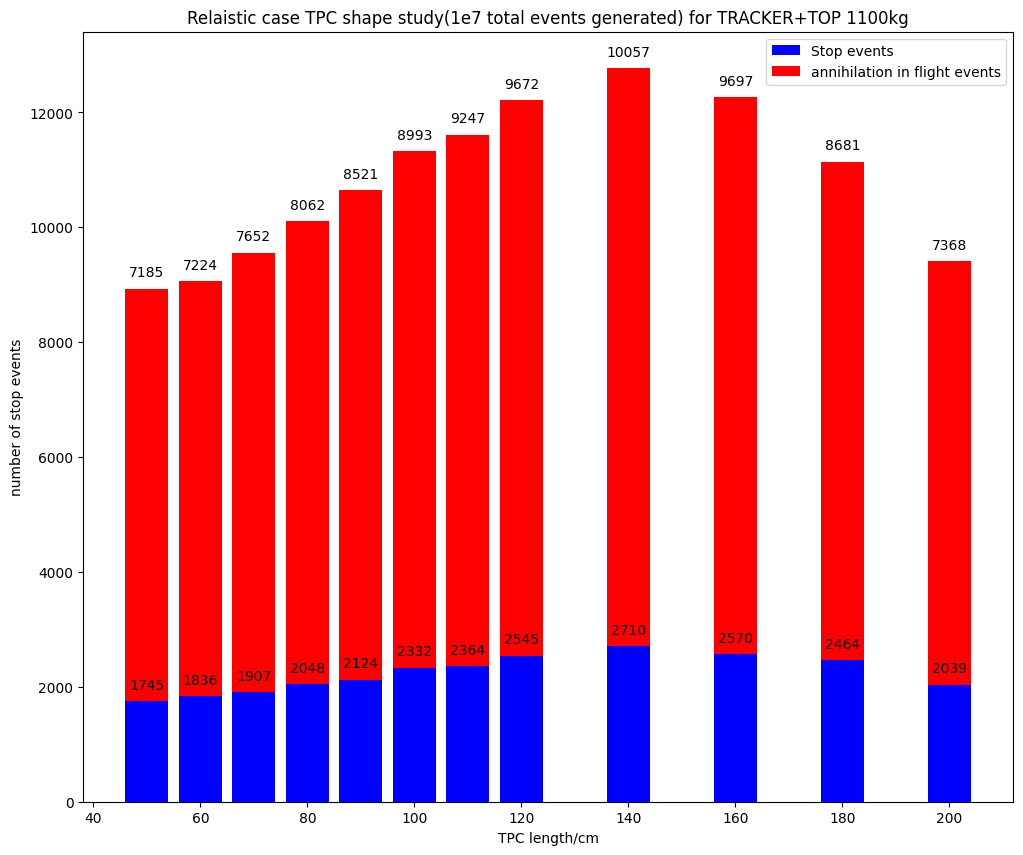

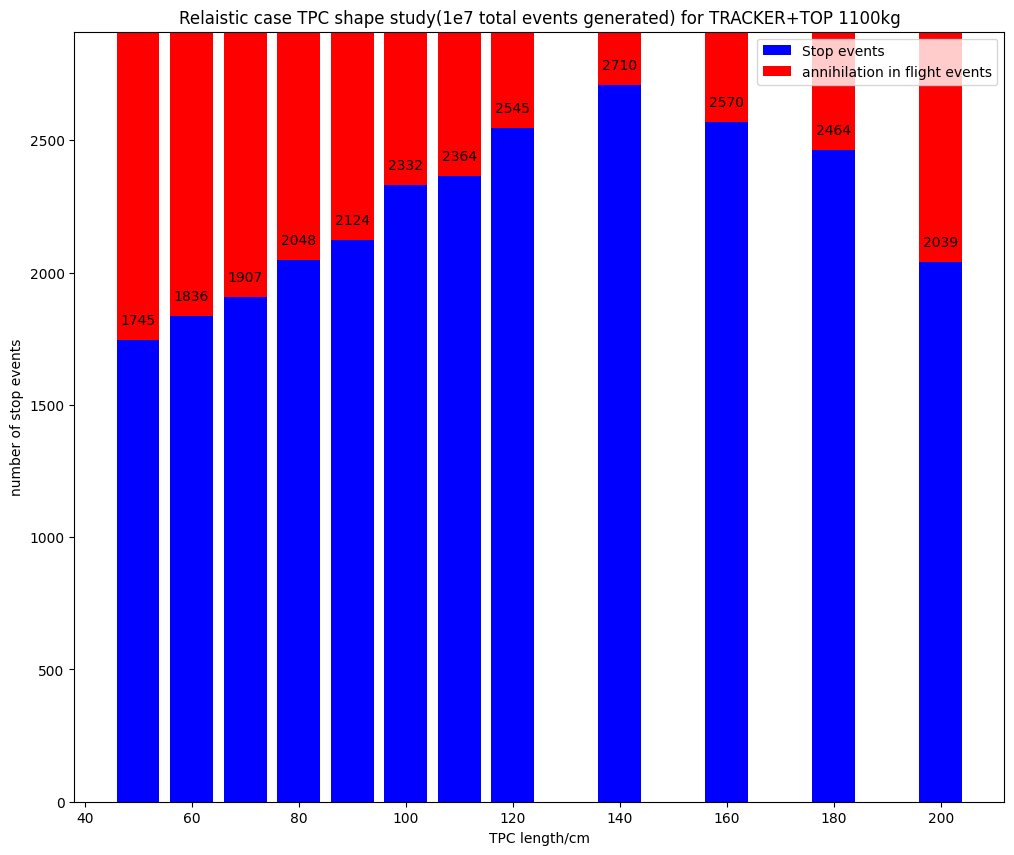

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(1)
plt.bar(TPC_length_1100, Events_1100_Stop, color='b', label='Stop events', width=8)
plt.bar(TPC_length_1100, Events_1100_In_Flight, color='r', bottom=Events_1100_Stop, label='annihilation in flight events', width=8)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("Relaistic case TPC shape study(1e7 total events generated) for TRACKER+TOP 1100kg")
for i, v in enumerate(Events_1100_Stop):
    plt.text(TPC_length_1100[i], Events_1100_Stop[i]+400, str(v), ha='center', va='top')
for i, v in enumerate(Events_1100_In_Flight):
    plt.text(TPC_length_1100[i], (Events_1100_Stop[i]+Events_1100_In_Flight[i])+400, str(v), ha='center', va='top')
plt.legend()

fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(2)
plt.bar(TPC_length_1100, Events_1100_Stop, color='b', label='Stop events', width=8)
plt.bar(TPC_length_1100, Events_1100_In_Flight, color='r', bottom=Events_1100_Stop, label='annihilation in flight events', width=8)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("Relaistic case TPC shape study(1e7 total events generated) for TRACKER+TOP 1100kg")
for i, v in enumerate(Events_1100_Stop):
    plt.text(TPC_length_1100[i], Events_1100_Stop[i]+100, str(v), ha='center', va='top')
plt.ylim(0, max(Events_1100_Stop)+200)
plt.legend()


Reading data...

Toy Model data imported
Found 8930 Events!
Now processing (8929/8930)
 We got 1745 events selected
Last event is 9997559
Reading data...

Toy Model data imported
Found 9060 Events!
Now processing (9059/9060)
 We got 1836 events selected
Last event is 9998357
Reading data...

Toy Model data imported
Found 9559 Events!
Now processing (9558/9559)
 We got 1907 events selected
Last event is 9997532
Reading data...

Toy Model data imported
Found 10110 Events!
Now processing (10109/10110)
 We got 2048 events selected
Last event is 9999488
Reading data...

Toy Model data imported
Found 10645 Events!
Now processing (10644/10645)
 We got 2124 events selected
Last event is 9999354
Reading data...

Toy Model data imported
Found 11325 Events!
Now processing (11324/11325)
 We got 2332 events selected
Last event is 9999976
Reading data...

Toy Model data imported
Found 11611 Events!
Now processing (11610/11611)
 We got 2364 events selected
Last event is 9999548
Reading data...

Toy M

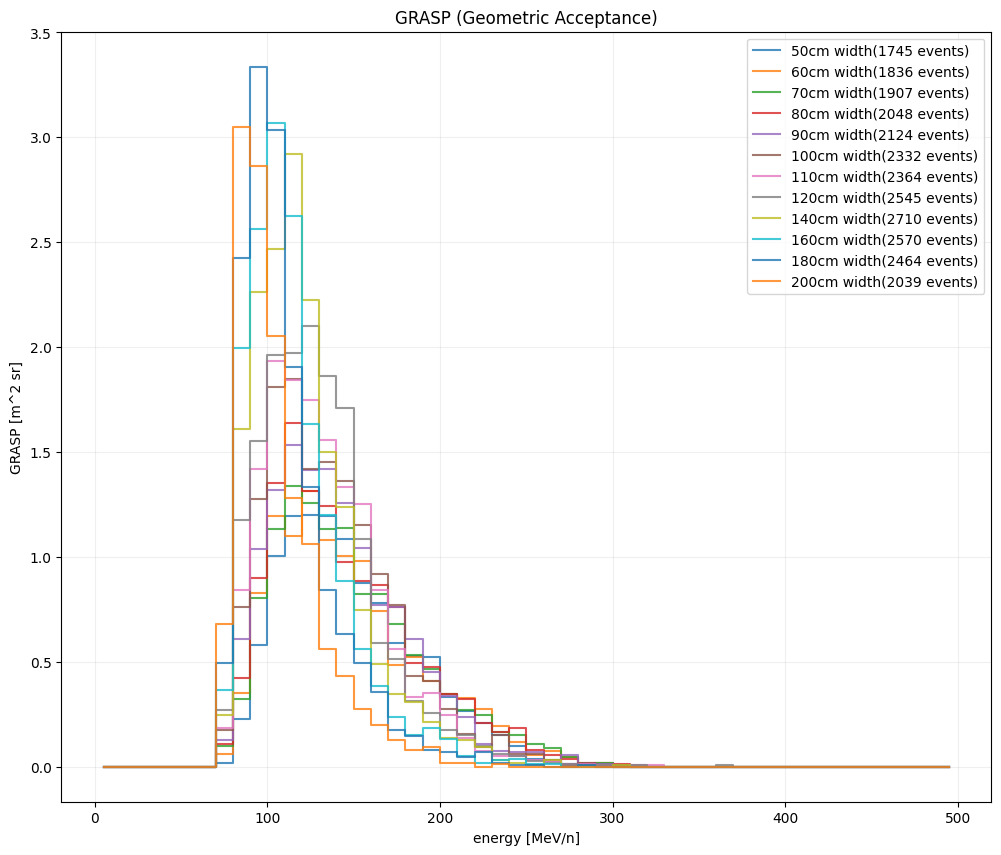

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))

Events_1100_Stop = []
TPC_length_1100 = []

plt.figure(1)

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_1100kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_50[0]))
TPC_length_1100.append(50)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = toy_model_analysis.GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm_1100kgTPC.dat'
label_60cm= '60cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_60[0]))
TPC_length_1100.append(60)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = toy_model_analysis.GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_70 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_70cm_1100kgTPC.dat'
label_70cm= '70cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_70 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_70), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_70[0]))
TPC_length_1100.append(70)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_70 = toy_model_analysis.GRASP_hist(GRASP_1e7_70[0], -1000010020, label_70cm, GRASP_1e7_70[1], 0, 1000, 50, ax=ax)
GRASP_1e7_70 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm_1100kgTPC.dat'
label_80cm= '80cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_80[0]))
TPC_length_1100.append(80)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = toy_model_analysis.GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm_1100kgTPC.dat'
label_90cm= '90cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_90[0]))
TPC_length_1100.append(90)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = toy_model_analysis.GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm_1100kgTPC.dat'
label_100cm= '100cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_100[0]))
TPC_length_1100.append(100)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = toy_model_analysis.GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_1100kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_110[0]))
TPC_length_1100.append(110)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = toy_model_analysis.GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm_1100kgTPC.dat'
label_120cm= '120cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_120[0]))
TPC_length_1100.append(120)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = toy_model_analysis.GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm_1100kgTPC.dat'
label_140cm= '140cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_140[0]))
TPC_length_1100.append(140)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = toy_model_analysis.GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm_1100kgTPC.dat'
label_160cm= '160cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_160[0]))
TPC_length_1100.append(160)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = toy_model_analysis.GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm_1100kgTPC.dat'
label_180cm= '180cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_180[0]))
TPC_length_1100.append(180)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = toy_model_analysis.GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_200cm_1100kgTPC.dat'
label_200cm= '200cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_200 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_200), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_200[0]))
TPC_length_1100.append(200)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_200 = toy_model_analysis.GRASP_hist(GRASP_1e7_200[0], -1000010020, label_200cm, GRASP_1e7_200[1], 0, 1000, 50, ax=ax)
GRASP_1e7_200 = None

"""
file_path_atmo_1e7_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_300cm_1100kgTPC.dat'
label_300cm= '300cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_300 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_300), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_300[0]))
TPC_length_1100.append(300)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_300 = toy_model_analysis.GRASP_hist(GRASP_1e7_300[0], -1000010020, label_300cm, GRASP_1e7_300[1], 0, 1000, 50, ax=ax)
GRASP_1e7_300 = None

file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm_1100kgTPC.dat'
label_1000cm= '1000cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=True, in_flight_event=False)
Events_1100_Stop.append(len(GRASP_1e7_1000[0]))
TPC_length_1100.append(1000)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = toy_model_analysis.GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None
"""

plt.show()  # Display the plot with both data on the same axes

Reading data...

Toy Model data imported
Found 8930 Events!
Now processing (8929/8930)
 We got 7185 events selected
Last event is 9997559
Reading data...

Toy Model data imported
Found 9060 Events!
Now processing (9059/9060)
 We got 7224 events selected
Last event is 9998357
Reading data...

Toy Model data imported
Found 9559 Events!
Now processing (9558/9559)
 We got 7652 events selected
Last event is 9997532
Reading data...

Toy Model data imported
Found 10110 Events!
Now processing (10109/10110)
 We got 8062 events selected
Last event is 9999488
Reading data...

Toy Model data imported
Found 10645 Events!
Now processing (10644/10645)
 We got 8521 events selected
Last event is 9999354
Reading data...

Toy Model data imported
Found 11325 Events!
Now processing (11324/11325)
 We got 8993 events selected
Last event is 9999976
Reading data...

Toy Model data imported
Found 11611 Events!
Now processing (11610/11611)
 We got 9247 events selected
Last event is 9999548
Reading data...

Toy M

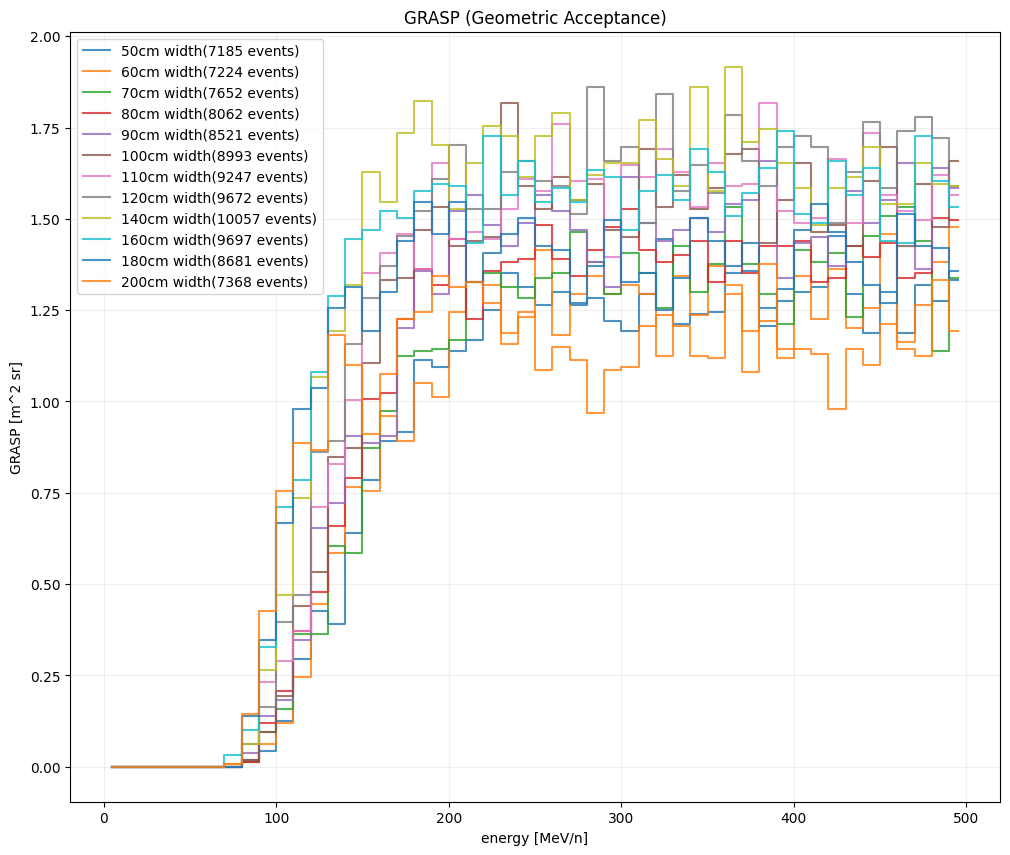

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

Events_1100_In_Flight = []
TPC_length_1100 = []

plt.figure(1)

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_1100kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_50[0]))
TPC_length_1100.append(50)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = toy_model_analysis.GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm_1100kgTPC.dat'
label_60cm= '60cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_60[0]))
TPC_length_1100.append(60)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = toy_model_analysis.GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_70 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_70cm_1100kgTPC.dat'
label_70cm= '70cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_70 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_70), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_70[0]))
TPC_length_1100.append(70)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_70 = toy_model_analysis.GRASP_hist(GRASP_1e7_70[0], -1000010020, label_70cm, GRASP_1e7_70[1], 0, 1000, 50, ax=ax)
GRASP_1e7_70 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm_1100kgTPC.dat'
label_80cm= '80cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_80[0]))
TPC_length_1100.append(80)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = toy_model_analysis.GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm_1100kgTPC.dat'
label_90cm= '90cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_90[0]))
TPC_length_1100.append(90)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = toy_model_analysis.GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm_1100kgTPC.dat'
label_100cm= '100cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_100[0]))
TPC_length_1100.append(100)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = toy_model_analysis.GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_1100kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_110[0]))
TPC_length_1100.append(110)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = toy_model_analysis.GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm_1100kgTPC.dat'
label_120cm= '120cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_120[0]))
TPC_length_1100.append(120)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = toy_model_analysis.GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm_1100kgTPC.dat'
label_140cm= '140cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_140[0]))
TPC_length_1100.append(140)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = toy_model_analysis.GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm_1100kgTPC.dat'
label_160cm= '160cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_160[0]))
TPC_length_1100.append(160)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = toy_model_analysis.GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm_1100kgTPC.dat'
label_180cm= '180cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_180[0]))
TPC_length_1100.append(180)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = toy_model_analysis.GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_200cm_1100kgTPC.dat'
label_200cm= '200cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_200 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_200), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_200[0]))
TPC_length_1100.append(200)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_200 = toy_model_analysis.GRASP_hist(GRASP_1e7_200[0], -1000010020, label_200cm, GRASP_1e7_200[1], 0, 1000, 50, ax=ax)
GRASP_1e7_200 = None

"""
file_path_atmo_1e7_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_300cm_1100kgTPC.dat'
label_300cm= '300cm width'


# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_300 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_300), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_300[0]))
TPC_length_1100.append(300)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_300 = toy_model_analysis.GRASP_hist(GRASP_1e7_300[0], -1000010020, label_300cm, GRASP_1e7_300[1], 0, 1000, 50, ax=ax)
GRASP_1e7_300 = None


file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm_1100kgTPC.dat'
label_1000cm= '1000cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=False, in_flight_event=True)
Events_1100_In_Flight.append(len(GRASP_1e7_1000[0]))
TPC_length_1100.append(1000)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = toy_model_analysis.GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None
"""

plt.show()  # Display the plot with both data on the same axes

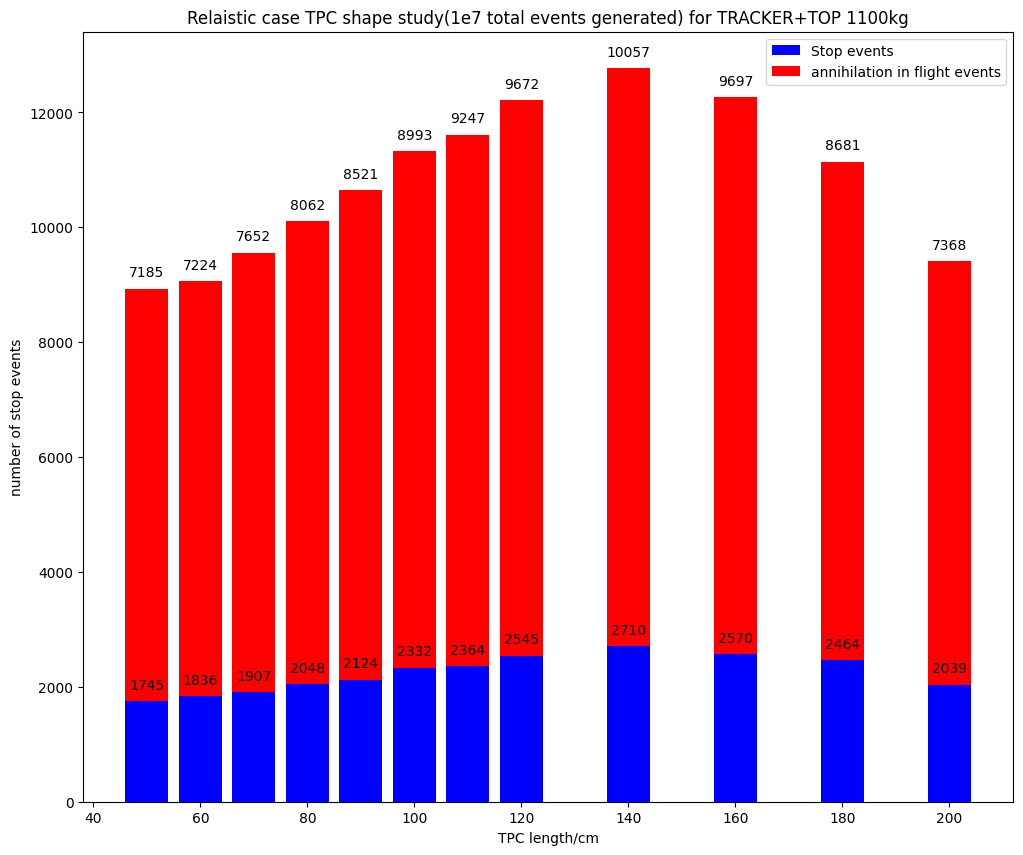

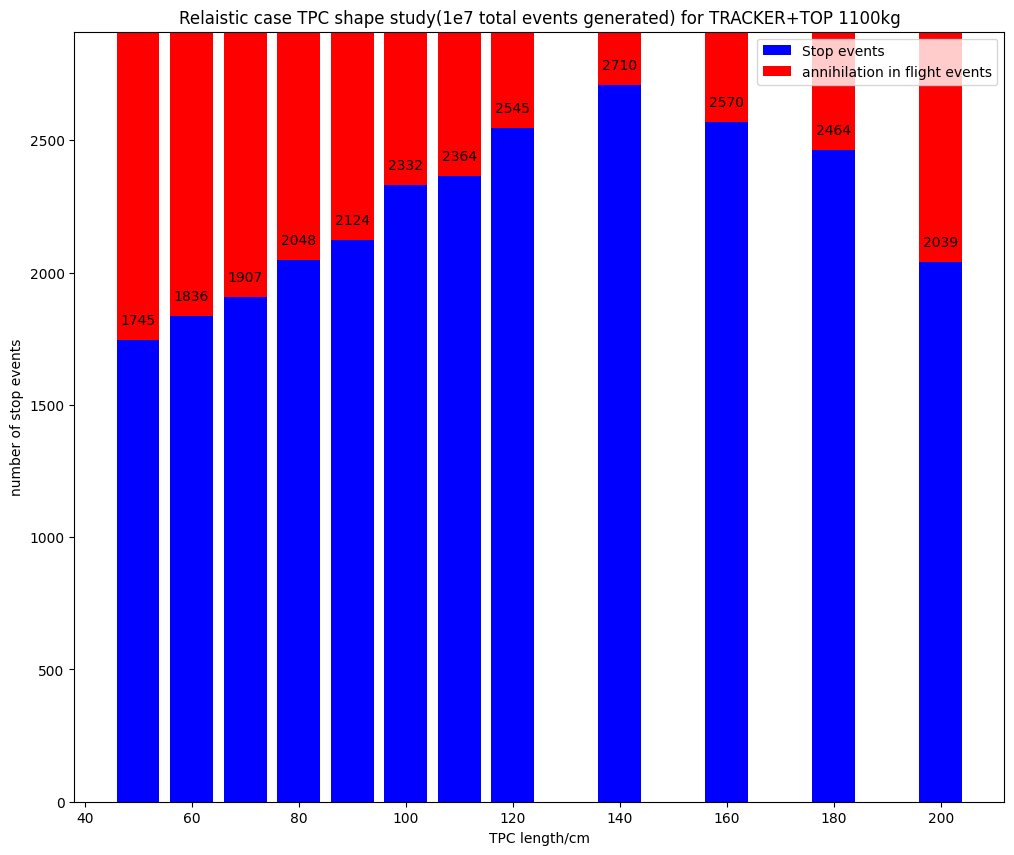

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(1)
plt.bar(TPC_length_1100, Events_1100_Stop, color='b', label='Stop events', width=8)
plt.bar(TPC_length_1100, Events_1100_In_Flight, color='r', bottom=Events_1100_Stop, label='annihilation in flight events', width=8)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("Relaistic case TPC shape study(1e7 total events generated) for TRACKER+TOP 1100kg")
for i, v in enumerate(Events_1100_Stop):
    plt.text(TPC_length_1100[i], Events_1100_Stop[i]+400, str(v), ha='center', va='top')
for i, v in enumerate(Events_1100_In_Flight):
    plt.text(TPC_length_1100[i], (Events_1100_Stop[i]+Events_1100_In_Flight[i])+400, str(v), ha='center', va='top')
plt.legend()

fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(2)
plt.bar(TPC_length_1100, Events_1100_Stop, color='b', label='Stop events', width=8)
plt.bar(TPC_length_1100, Events_1100_In_Flight, color='r', bottom=Events_1100_Stop, label='annihilation in flight events', width=8)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("Relaistic case TPC shape study(1e7 total events generated) for TRACKER+TOP 1100kg")
for i, v in enumerate(Events_1100_Stop):
    plt.text(TPC_length_1100[i], Events_1100_Stop[i]+100, str(v), ha='center', va='top')
plt.ylim(0, max(Events_1100_Stop)+200)
plt.legend()


Reading data...

Toy Model data imported
Found 11045 Events!
Now processing (11044/11045)
 We got 2184 events selected
Last event is 9998745
Reading data...

Toy Model data imported
Found 11481 Events!
Now processing (11480/11481)
 We got 2296 events selected
Last event is 9999947
Reading data...

Toy Model data imported
Found 11556 Events!
Now processing (11555/11556)
 We got 2321 events selected
Last event is 9999065
Reading data...

Toy Model data imported
Found 12223 Events!
Now processing (12222/12223)
 We got 2472 events selected
Last event is 9999959
Reading data...

Toy Model data imported
Found 13019 Events!
Now processing (13018/13019)
 We got 2597 events selected
Last event is 9999951
Reading data...

Toy Model data imported
Found 13560 Events!
Now processing (13559/13560)
 We got 2756 events selected
Last event is 9999953
Reading data...

Toy Model data imported
Found 14384 Events!
Now processing (14383/14384)
 We got 2862 events selected
Last event is 9999803
Reading data.

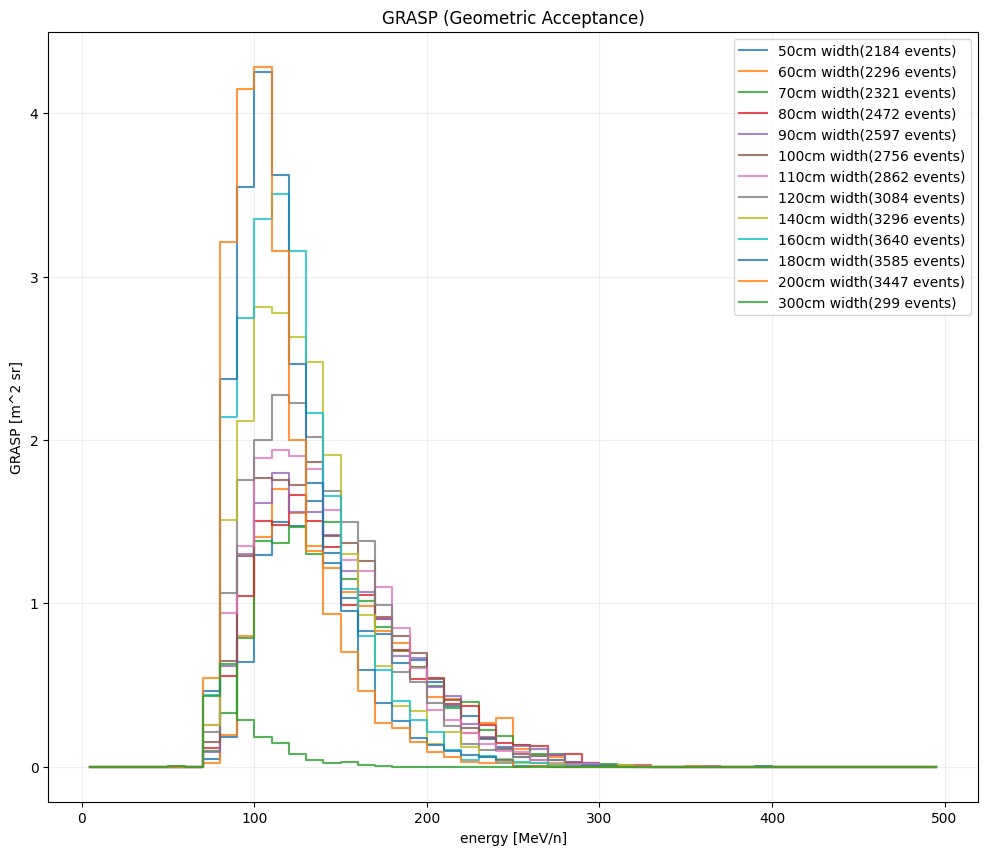

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))

Events_1300_Stop = []
TPC_length_1300 = []

plt.figure(1)

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_1300kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_50[0]))
TPC_length_1300.append(50)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = toy_model_analysis.GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm_1300kgTPC.dat'
label_60cm= '60cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_60[0]))
TPC_length_1300.append(60)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = toy_model_analysis.GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_70 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_70cm_1300kgTPC.dat'
label_70cm= '70cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_70 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_70), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_70[0]))
TPC_length_1300.append(70)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_70 = toy_model_analysis.GRASP_hist(GRASP_1e7_70[0], -1000010020, label_70cm, GRASP_1e7_70[1], 0, 1000, 50, ax=ax)
GRASP_1e7_70 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm_1300kgTPC.dat'
label_80cm= '80cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_80[0]))
TPC_length_1300.append(80)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = toy_model_analysis.GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm_1300kgTPC.dat'
label_90cm= '90cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_90[0]))
TPC_length_1300.append(90)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = toy_model_analysis.GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm_1300kgTPC.dat'
label_100cm= '100cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_100[0]))
TPC_length_1300.append(100)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = toy_model_analysis.GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_1300kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_110[0]))
TPC_length_1300.append(110)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = toy_model_analysis.GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm_1300kgTPC.dat'
label_120cm= '120cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_120[0]))
TPC_length_1300.append(120)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = toy_model_analysis.GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm_1300kgTPC.dat'
label_140cm= '140cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_140[0]))
TPC_length_1300.append(140)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = toy_model_analysis.GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm_1300kgTPC.dat'
label_160cm= '160cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_160[0]))
TPC_length_1300.append(160)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = toy_model_analysis.GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm_1300kgTPC.dat'
label_180cm= '180cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_180[0]))
TPC_length_1300.append(180)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = toy_model_analysis.GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_200cm_1300kgTPC.dat'
label_200cm= '200cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_200 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_200), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_200[0]))
TPC_length_1300.append(200)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_200 = toy_model_analysis.GRASP_hist(GRASP_1e7_200[0], -1000010020, label_200cm, GRASP_1e7_200[1], 0, 1000, 50, ax=ax)
GRASP_1e7_200 = None


file_path_atmo_1e7_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_300cm_1300kgTPC.dat'
label_300cm= '300cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_300 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_300), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_300[0]))
TPC_length_1300.append(300)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_300 = toy_model_analysis.GRASP_hist(GRASP_1e7_300[0], -1000010020, label_300cm, GRASP_1e7_300[1], 0, 1000, 50, ax=ax)
GRASP_1e7_300 = None

"""
file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm_1300kgTPC.dat'
label_1000cm= '1000cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=True, in_flight_event=False)
Events_1300_Stop.append(len(GRASP_1e7_1000[0]))
TPC_length_1300.append(1000)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = toy_model_analysis.GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None
"""

plt.show()  # Display the plot with both data on the same axes

Reading data...

Toy Model data imported
Found 11045 Events!
Now processing (11044/11045)
 We got 8861 events selected
Last event is 9998745
Reading data...

Toy Model data imported
Found 11481 Events!
Now processing (11480/11481)
 We got 9185 events selected
Last event is 9999947
Reading data...

Toy Model data imported
Found 11556 Events!
Now processing (11555/11556)
 We got 9235 events selected
Last event is 9999065
Reading data...

Toy Model data imported
Found 12223 Events!
Now processing (12222/12223)
 We got 9751 events selected
Last event is 9999959
Reading data...

Toy Model data imported
Found 13019 Events!
Now processing (13018/13019)
 We got 10422 events selected
Last event is 9999951
Reading data...

Toy Model data imported
Found 13560 Events!
Now processing (13559/13560)
 We got 10804 events selected
Last event is 9999953
Reading data...

Toy Model data imported
Found 14384 Events!
Now processing (14383/14384)
 We got 11522 events selected
Last event is 9999803
Reading da

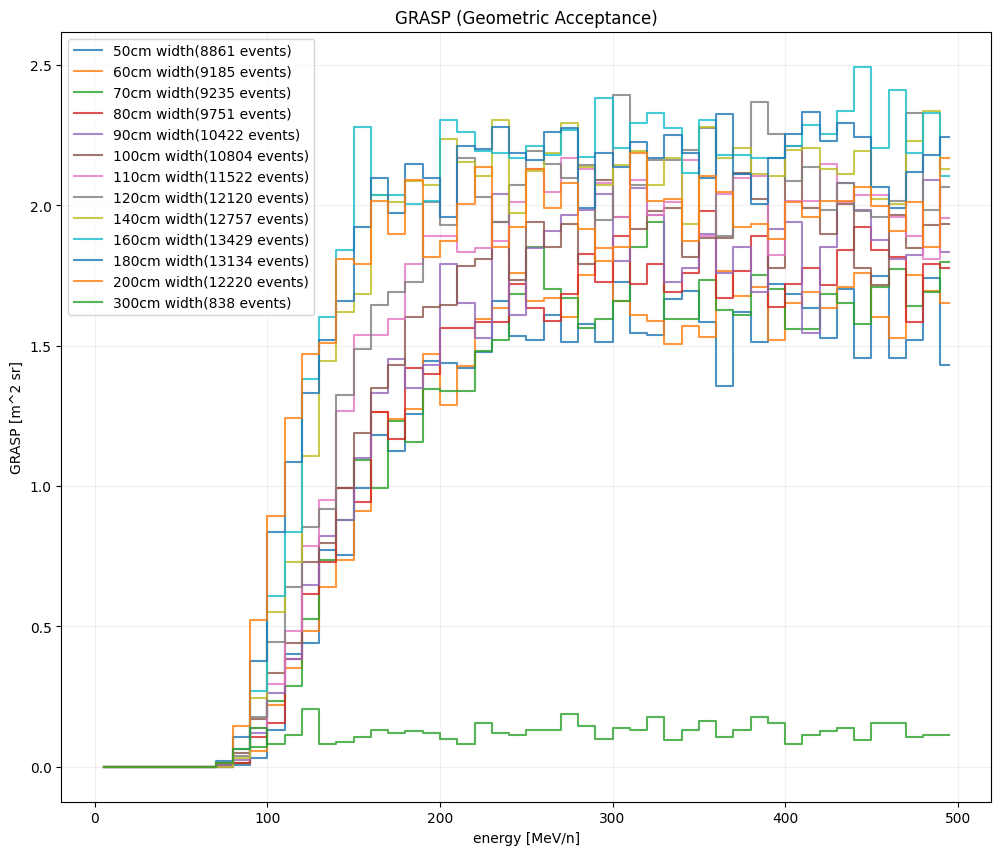

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))

Events_1300_In_Flight = []
TPC_length_1300 = []

plt.figure(1)

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_1300kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_50[0]))
TPC_length_1300.append(50)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = toy_model_analysis.GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm_1300kgTPC.dat'
label_60cm= '60cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_60[0]))
TPC_length_1300.append(60)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = toy_model_analysis.GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_70 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_70cm_1300kgTPC.dat'
label_70cm= '70cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_70 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_70), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_70[0]))
TPC_length_1300.append(70)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_70 = toy_model_analysis.GRASP_hist(GRASP_1e7_70[0], -1000010020, label_70cm, GRASP_1e7_70[1], 0, 1000, 50, ax=ax)
GRASP_1e7_70 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm_1300kgTPC.dat'
label_80cm= '80cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_80[0]))
TPC_length_1300.append(80)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = toy_model_analysis.GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm_1300kgTPC.dat'
label_90cm= '90cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_90[0]))
TPC_length_1300.append(90)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = toy_model_analysis.GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm_1300kgTPC.dat'
label_100cm= '100cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_100[0]))
TPC_length_1300.append(100)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = toy_model_analysis.GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_1300kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_110[0]))
TPC_length_1300.append(110)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = toy_model_analysis.GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm_1300kgTPC.dat'
label_120cm= '120cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_120[0]))
TPC_length_1300.append(120)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = toy_model_analysis.GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm_1300kgTPC.dat'
label_140cm= '140cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_140[0]))
TPC_length_1300.append(140)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = toy_model_analysis.GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm_1300kgTPC.dat'
label_160cm= '160cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_160[0]))
TPC_length_1300.append(160)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = toy_model_analysis.GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm_1300kgTPC.dat'
label_180cm= '180cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_180[0]))
TPC_length_1300.append(180)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = toy_model_analysis.GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_200cm_1300kgTPC.dat'
label_200cm= '200cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_200 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_200), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_200[0]))
TPC_length_1300.append(200)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_200 = toy_model_analysis.GRASP_hist(GRASP_1e7_200[0], -1000010020, label_200cm, GRASP_1e7_200[1], 0, 1000, 50, ax=ax)
GRASP_1e7_200 = None

file_path_atmo_1e7_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_300cm_1300kgTPC.dat'
label_300cm= '300cm width'


# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_300 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_300), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_300[0]))
TPC_length_1300.append(300)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_300 = toy_model_analysis.GRASP_hist(GRASP_1e7_300[0], -1000010020, label_300cm, GRASP_1e7_300[1], 0, 1000, 50, ax=ax)
GRASP_1e7_300 = None

"""
file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm_1300kgTPC.dat'
label_1000cm= '1000cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = toy_model_analysis.Analyze_GRASP(toy_model_analysis.read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=False, in_flight_event=True)
Events_1300_In_Flight.append(len(GRASP_1e7_1000[0]))
TPC_length_1300.append(1000)

# variable explaination: toy_model_analysis.GRASP_hist(GRASP_vector_from_toy_model_analysis.Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = toy_model_analysis.GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None
"""

plt.show()  # Display the plot with both data on the same axes

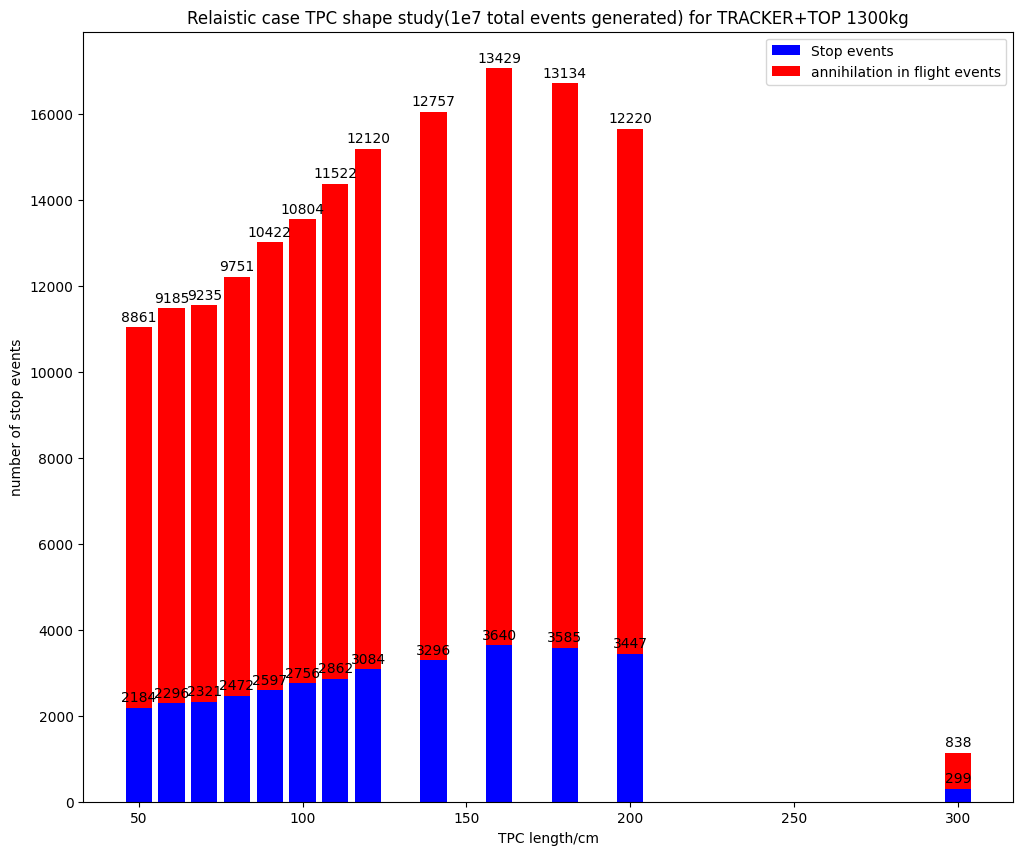

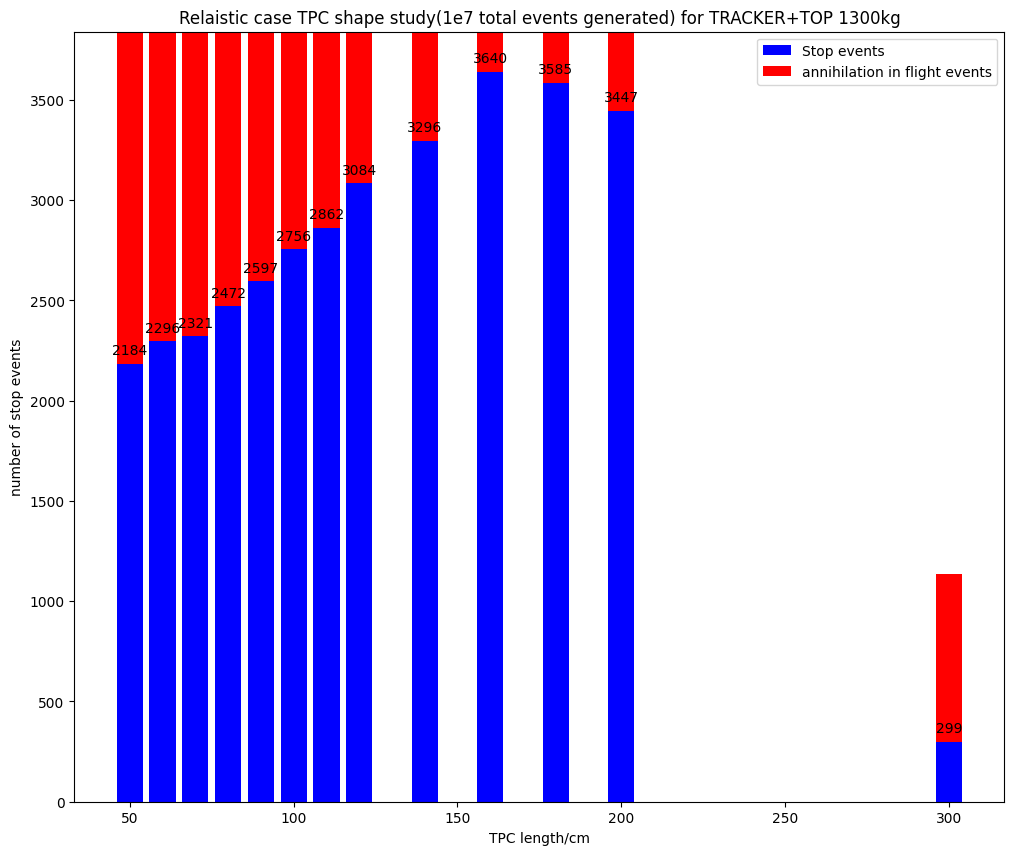

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(1)
plt.bar(TPC_length_1300, Events_1300_Stop, color='b', label='Stop events', width=8)
plt.bar(TPC_length_1300, Events_1300_In_Flight, color='r', bottom=Events_1300_Stop, label='annihilation in flight events', width=8)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("Relaistic case TPC shape study(1e7 total events generated) for TRACKER+TOP 1300kg")
for i, v in enumerate(Events_1300_Stop):
    plt.text(TPC_length_1300[i], Events_1300_Stop[i]+400, str(v), ha='center', va='top')
for i, v in enumerate(Events_1300_In_Flight):
    plt.text(TPC_length_1300[i], (Events_1300_Stop[i]+Events_1300_In_Flight[i])+400, str(v), ha='center', va='top')
plt.legend()

fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(2)
plt.bar(TPC_length_1300, Events_1300_Stop, color='b', label='Stop events', width=8)
plt.bar(TPC_length_1300, Events_1300_In_Flight, color='r', bottom=Events_1300_Stop, label='annihilation in flight events', width=8)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("Relaistic case TPC shape study(1e7 total events generated) for TRACKER+TOP 1300kg")
for i, v in enumerate(Events_1300_Stop):
    plt.text(TPC_length_1300[i], Events_1300_Stop[i]+100, str(v), ha='center', va='top')
plt.ylim(0, max(Events_1300_Stop)+200)
plt.legend()


In [ ]:
"""
This is for trace inside LArTPC study
"""

file_path_1 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm_900kgTPC.dat'
label_50cm= '50cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
trace_1 = toy_model_analysis.Analyze_trace(toy_model_analysis.read_data_from_toymodel(file_path_1), -1000010020, stop_event=True, in_flight_event=True)

file_path_2 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm_900kgTPC.dat'
label_110cm= '110cm width'

# variable explaination: toy_model_analysis.Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
trace_2 = toy_model_analysis.Analyze_trace(toy_model_analysis.read_data_from_toymodel(file_path_2), -1000010020, stop_event=True, in_flight_event=True)

plt.figure(1, figsize=(12, 10))
plt.hist(trace_1[1], bins = 50, alpha = 0.8, label='50cm TPC captured '+ str(len(trace_1[1]))+' events', range=[0, 100])
plt.hist(trace_2[1], bins = 50, alpha = 0.8, label='110cm TPC captured '+ str(len(trace_2[1]))+' events', range=[0, 100])
plt.title("Depth in LAr")
plt.xlabel("z/cm")
plt.ylabel("Number of Events")
plt.legend()

plt.figure(2, figsize=(12, 10))
plt.hist(trace_1[2], bins = 50, alpha = 0.8, label='50cm TPC captured '+ str(len(trace_1[1]))+' events', range=[0, 100])
plt.hist(trace_2[2], bins = 50, alpha = 0.8, label='110cm TPC captured '+ str(len(trace_2[1]))+' events', range=[0, 100])
plt.title("Distance in LAr")
plt.xlabel("d/cm")
plt.ylabel("Number of Events")
plt.legend()

# For clear cache
trace_1 = None
trace_2 = None

### 